In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'D:/zzStudies/CSE499/BSL'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train/train")

['test', 'train']


In [3]:
transform = tt.Compose(
    [
        tt.RandomRotation(degrees=15),
        tt.Resize(64), #was 32
        tt.Grayscale(num_output_channels=1),
        tt.ToTensor(),
        tt.Normalize([0.5], [0.5])
    ]
)
dataset = ImageFolder(data_dir+"/train/train", transform)

In [4]:
print(dataset.classes)

['nothing', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'উ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'প', 'ফ', 'ব', 'ম', 'ল', 'শ', 'হ']


In [5]:
random_seed = 42
torch.manual_seed(random_seed);
print(len(dataset))

34069


In [6]:
val_size = 6800
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

print(len(train_ds), len(val_ds))

27269 6800


In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow((img.permute(1, 2, 0)))

Label:  nothing (0)


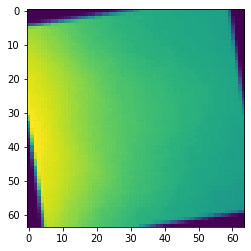

In [8]:
show_example(*dataset[0])

In [9]:
def get_default_device():
    # Pick GPU if available, else CPU 
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move tensor(s) to chosen device 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device 
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
     #   Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
     #   Number of batches
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
batch_size= 512

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


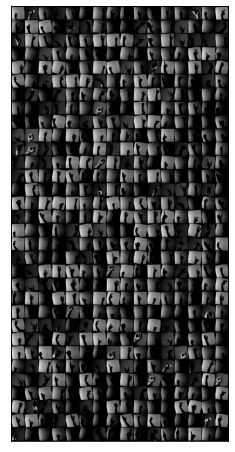

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ASLModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                                # input: 256 x 1 x 64 x 64   
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),                                         
            nn.MaxPool2d(2, 2), # output: 32 x 32 x 32 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),  # output: 128 x 16 x 16
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 8 x 8
            
            nn.Dropout(0.50),
            
            nn.Flatten(),
            nn.Linear(256*8*8, 39)) 
            
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = ASLModel()
to_device(model, device);
model

ASLModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_s

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        loop = tqdm(train_loader)
        # Training Phase 
        model.train()
        train_losses = []
        for batch in loop:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ASLModel(), device)

In [21]:
history = [evaluate(model, val_dl)]
history

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.12s/it]


[{'val_loss': 3.6630325317382812, 'val_acc': 0.03497590869665146}]

In [22]:
num_epochs = 100
opt_func = torch.optim.SGD
lr = 0.001

In [23]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.5580, val_loss: 3.0846, val_acc: 0.2193


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.0183, val_loss: 2.6629, val_acc: 0.2914


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.6991, val_loss: 2.4272, val_acc: 0.3456


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.4998, val_loss: 2.2668, val_acc: 0.3888


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.3504, val_loss: 2.1222, val_acc: 0.4468


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.2200, val_loss: 2.0344, val_acc: 0.4494


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.1181, val_loss: 1.9356, val_acc: 0.4710


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.0182, val_loss: 1.8502, val_acc: 0.5006


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.9409, val_loss: 1.7720, val_acc: 0.5325


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.8684, val_loss: 1.6960, val_acc: 0.5546


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.7996, val_loss: 1.6351, val_acc: 0.5475


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.7308, val_loss: 1.5742, val_acc: 0.5895


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.6671, val_loss: 1.5124, val_acc: 0.6053


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.6077, val_loss: 1.4665, val_acc: 0.6148


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.5636, val_loss: 1.4030, val_acc: 0.6403


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.5052, val_loss: 1.3538, val_acc: 0.6470


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.4506, val_loss: 1.2972, val_acc: 0.6709


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.4090, val_loss: 1.2598, val_acc: 0.6615


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.3520, val_loss: 1.2034, val_acc: 0.6894


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.3101, val_loss: 1.1665, val_acc: 0.7054


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.2714, val_loss: 1.1246, val_acc: 0.7162


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.2267, val_loss: 1.0917, val_acc: 0.7195


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.1852, val_loss: 1.0531, val_acc: 0.7404


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.1568, val_loss: 1.0152, val_acc: 0.7348


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.1240, val_loss: 0.9718, val_acc: 0.7670


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.0765, val_loss: 0.9452, val_acc: 0.7549


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.0477, val_loss: 0.9054, val_acc: 0.7812


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.0145, val_loss: 0.8877, val_acc: 0.7808


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.9777, val_loss: 0.8525, val_acc: 0.7944


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.9556, val_loss: 0.8273, val_acc: 0.8034


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.9330, val_loss: 0.7917, val_acc: 0.8258


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.9062, val_loss: 0.7821, val_acc: 0.8165


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.8709, val_loss: 0.7469, val_acc: 0.8276


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.8465, val_loss: 0.7269, val_acc: 0.8282


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.8184, val_loss: 0.7041, val_acc: 0.8429


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.8007, val_loss: 0.6820, val_acc: 0.8403


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.7743, val_loss: 0.6606, val_acc: 0.8602


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.7549, val_loss: 0.6370, val_acc: 0.8686


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.7420, val_loss: 0.6289, val_acc: 0.8644


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.7219, val_loss: 0.6031, val_acc: 0.8686


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.7086, val_loss: 0.5904, val_acc: 0.8745


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.6891, val_loss: 0.5712, val_acc: 0.8793


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.6686, val_loss: 0.5606, val_acc: 0.8810


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.6539, val_loss: 0.5451, val_acc: 0.8876


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
history = [evaluate(model, val_dl)]
history

In [ ]:
torch.save(model.state_dict(), 'CNN0.pth')

In [ ]:
#torch.save(model.state_dict(), 'CNN0.h5')

In [ ]:
def predict_single(input, target, model):
    predictions = model(input)
    _, preds = torch.max(predictions, dim=1)
    
    print("Target:", target)
    print("Prediction:", preds)
    print("Predicted Label:", dataset.classes[preds[0]])


In [ ]:
for input, label in val_dl:
    show_example(input[10].cpu(), label[10].cpu())
    predict_single(input[10].view(1, 1, 64, 64), label[10], model) # Was predict_single(input[0].view(1, 3, 32, 32)
    break